# 4.2.2 CD4+ T-cells analysis
**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-21"

## Introduction

CD4+ cells only

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(harmony)
library(scater) 
library(scran)
library(ComplexHeatmap)
library(EnhancedVolcano)
}))

In [3]:
set.seed(0)
source(here("utils/bin.R"))
source(here("utils/style.R"))

source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))

## Load data

In [4]:
cd4_clusters <- c("2","5","6","9_0", "9_1","11","13")
seurat_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.2-subset_tcell_noannot.rds")))

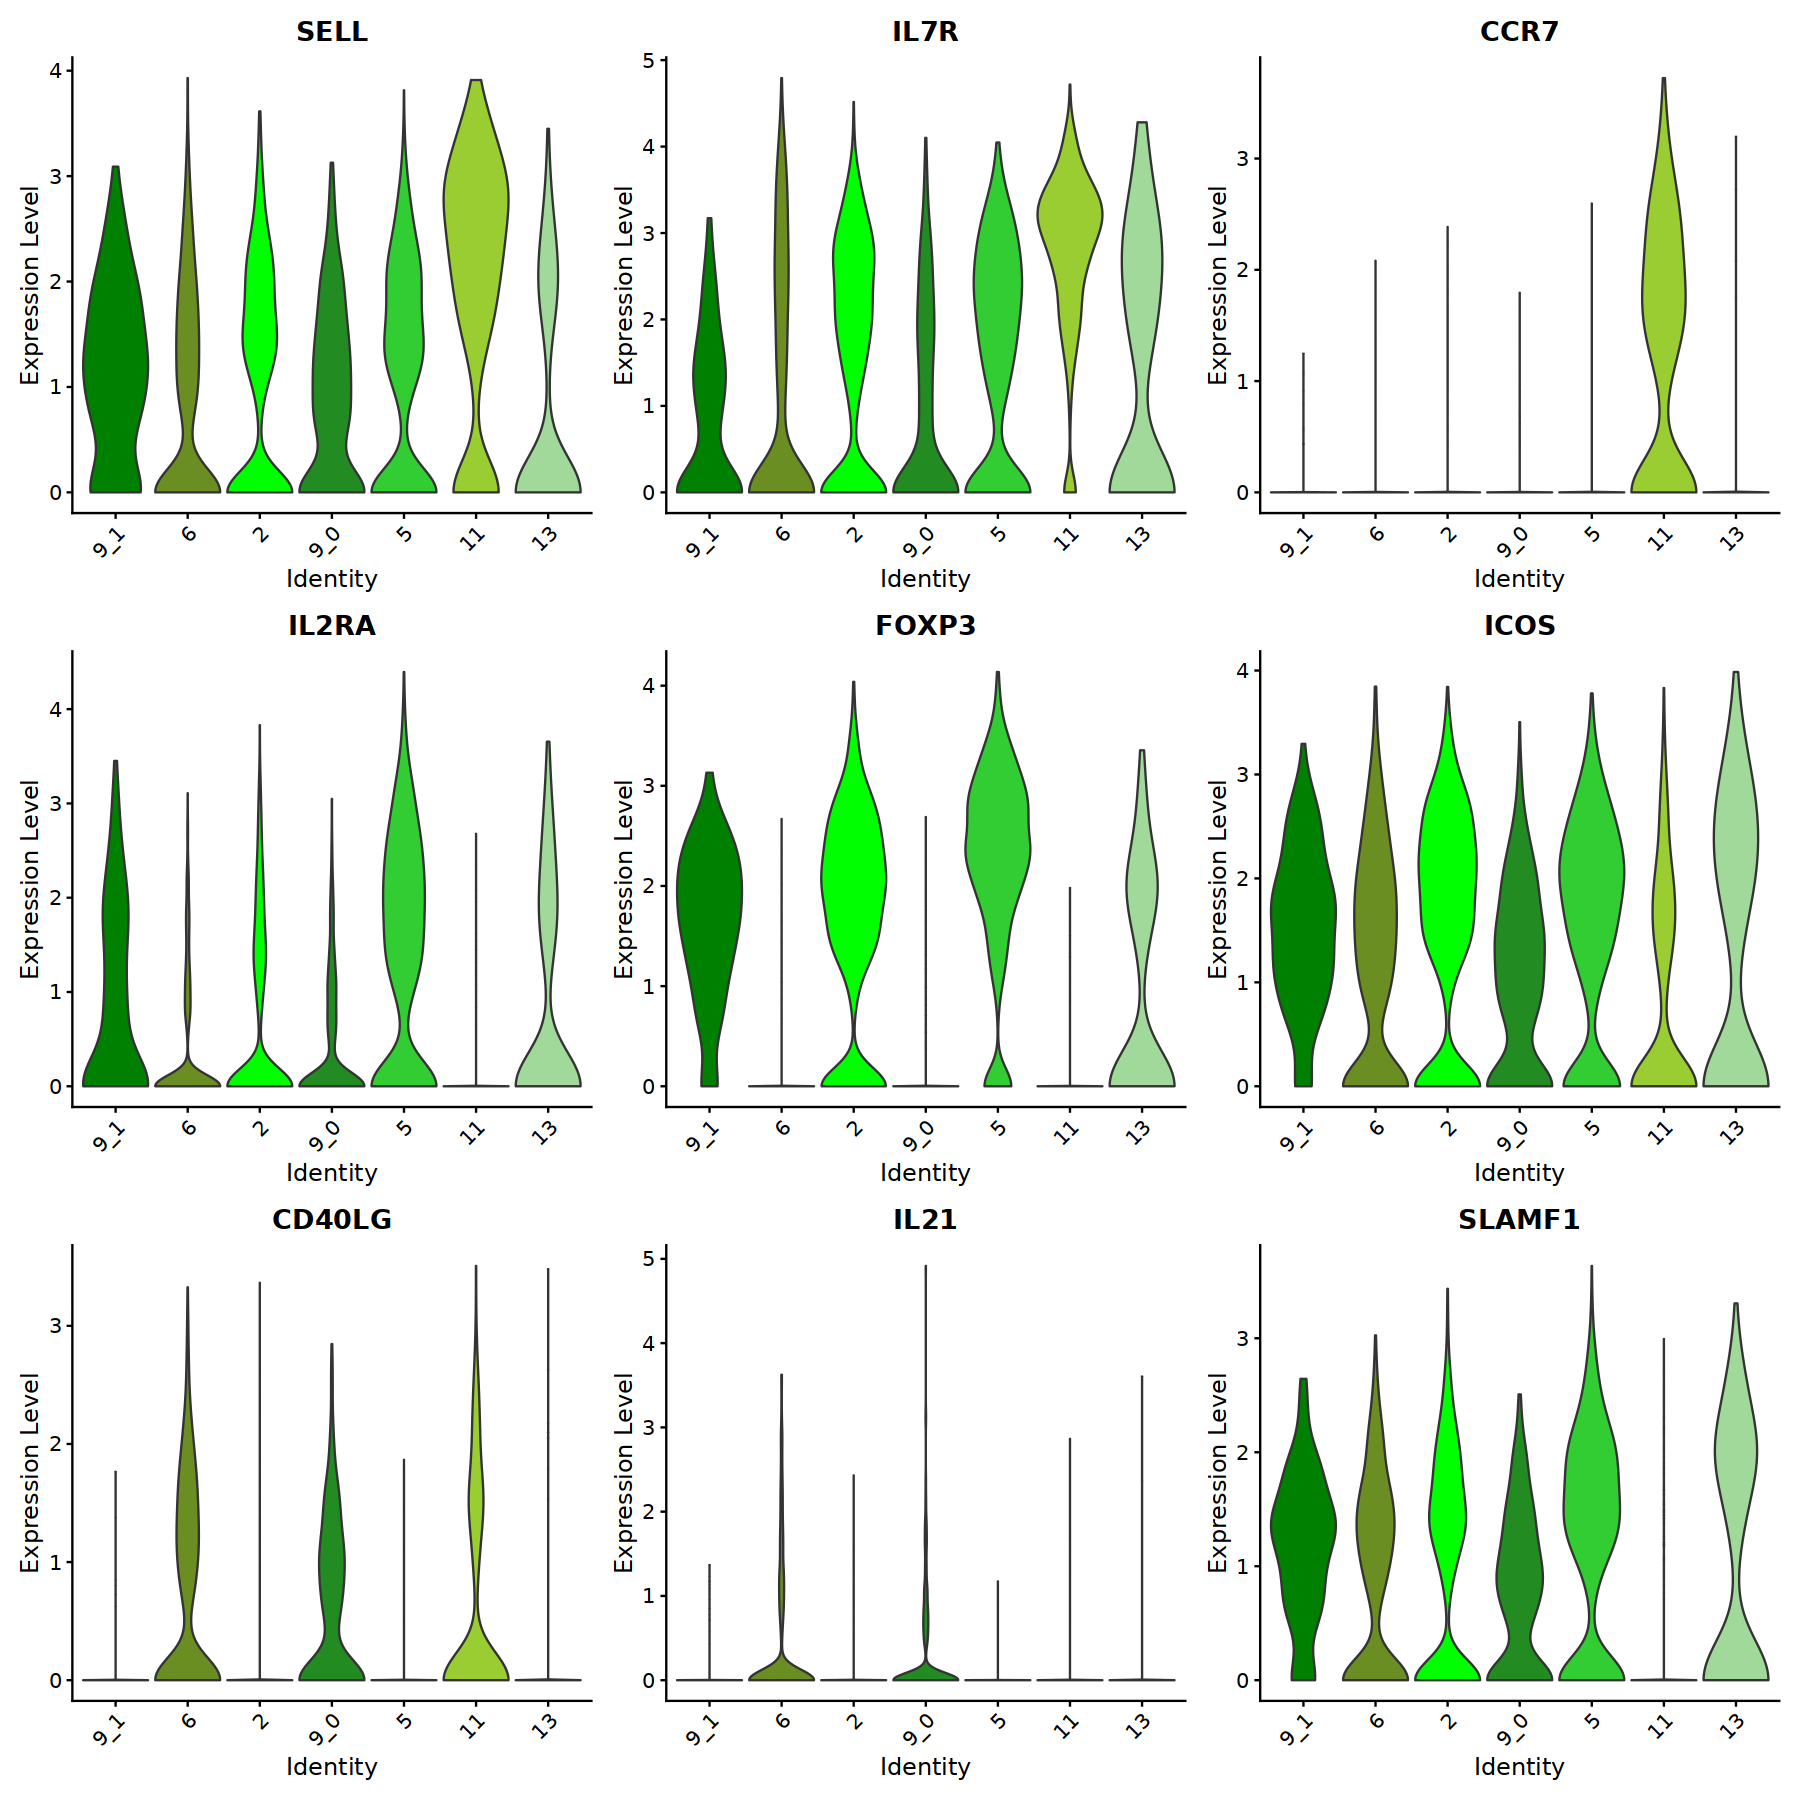

In [5]:
options(repr.plot.width = 15, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, cols=tumor_pal, idents = cd4_clusters,
            feature=c("SELL","IL7R","CCR7",
                      "IL2RA", "FOXP3","ICOS", 
                      "CD40LG", "IL21", "SLAMF1"), ncol=3, pt.size = 0)

## Tregs

In [6]:
treg_obj <- subset(x = seurat_obj, idents=c("2", "5", "9_1", "13"))

In [7]:
print(table(rowSums(as.matrix(treg_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(treg_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
treg_obj[['RNA']]@counts <- treg_obj[['RNA']]@counts[rownames(keep_genes), ]
treg_obj[['RNA']]@data <- treg_obj[['RNA']]@data[rownames(keep_genes), ]


FALSE  TRUE 
21976  4741 


In [8]:
treg_obj <- Seurat::DietSeurat(treg_obj,
                           counts = TRUE,
                           data = TRUE,
                           assays = c("RNA"),
                           dimreducs = NULL,
                           graphs = NULL)

In [9]:
list_objects <- SplitObject(treg_obj, split.by = "sample_id")
fractions <- names(list_objects)

In [10]:
find_hvgs <- function(sam, list_objects) {
    
    list_objects[[sam]] <- list_objects[[sam]]  %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4)
    
    sce <- as.SingleCellExperiment(list_objects[[sam]])
    gene_var <- modelGeneVar(sce)
    
    tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)
    
    plt <- gene_var %>% 
        as.data.frame() %>% 
        ggplot(aes(mean, total)) +
        geom_point() +
        geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
        labs(x = "Mean of log-expression", y = "Variance of log-expression") + 
        ggtitle(sam) +
        geom_text(data=tops, aes(mean,total,label=rownames(tops)))
    
    hvg <- getTopHVGs(gene_var,fdr.threshold = 0.05)
    list(plots=plt, hvgs=hvg)  
}

plts <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$plots)
hvgs <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$hvgs)

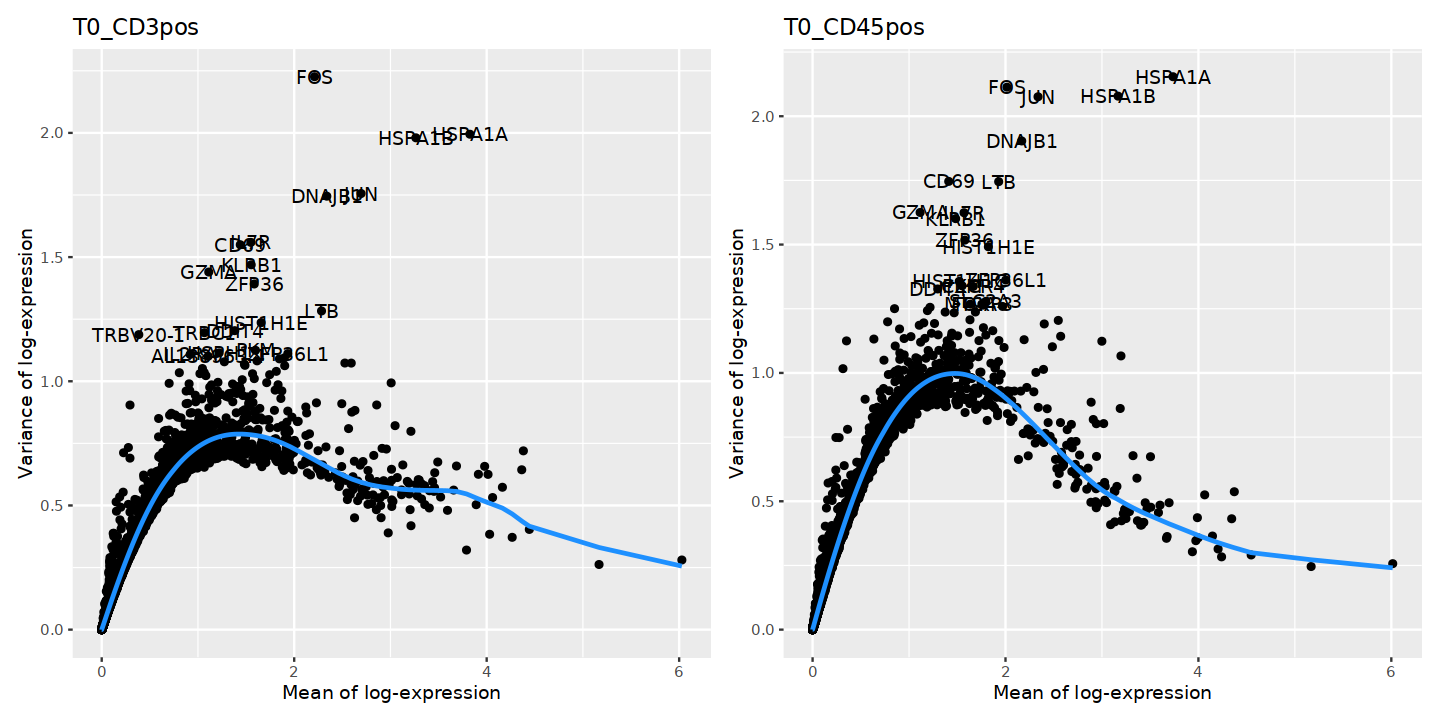

In [11]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
plts[[1]]+plts[[2]]

In [12]:
hvg_common <- union(hvgs[[1]], hvgs[[2]])
length(hvg_common)

[1] 1833

### Normalization and Embedding

In [13]:
treg_obj <- NormalizeData(
treg_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)
treg_obj <- treg_obj %>%
  ScaleData(features=hvg_common) %>% 
  RunPCA(features=hvg_common)

Centering and scaling data matrix

PC_ 1 
Positive:  MKI67, STMN1, TOP2A, RRM2, GAPDH, HIST1H3C, CENPF, ASPM, PKM, HIST1H3B 
	   ACTG1, HIST1H1B, HIST1H2AH, TUBA1B, MT2A, HIST1H1C, HIST1H1E, LGALS1, CD74, S100A4 
	   IL32, GZMA, CST7, FOXP3, CTLA4, NKG7, HLA-DRA, TIMP1, IL2RA, ACTG2 
Negative:  HSPA1A, HSPA1B, DNAJB1, JUN, FOS, HSP90AA1, HSPH1, CXCR4, TXNIP, FOSB 
	   BTG2, HSPA8, JUNB, TSPYL2, HSP90AB1, CD69, TAGAP, UBC, EGR1, IL7R 
	   CRYBG1, RTKN2, HSPA6, DEPP1, ZFP36, ANXA1, PDE3B, PDE7B, CD40LG, TNF 
PC_ 2 
Positive:  IL32, TMSB4X, S100A4, TPT1, GAPDH, H3F3B, UBC, ACTG1, IFITM1, CST7 
	   CD74, FOS, LTB, FOXP3, SAT1, MT2A, HSPA8, RGS1, JUN, HSP90AB1 
	   TIMP1, ZFP36, PKM, HIST1H1C, HSPA1A, JUNB, BATF, AL138963.4, GZMA, ZFP36L1 
Negative:  PDE3B, NEAT1, CRYBG1, PDE7B, MTRNR2L12, RRM2, AL136456.1, TOP2A, MKI67, RBMS3 
	   AC090125.1, IGSF9B, ASPM, CENPF, TP63, PEX7, LINC02312, IL7R, CD40LG, AL591623.1 
	   HDAC9, STMN1, SOX2-OT, CH25H, AL138828.1, HIST1H3C, LINC01135, UBTD2, MSANT

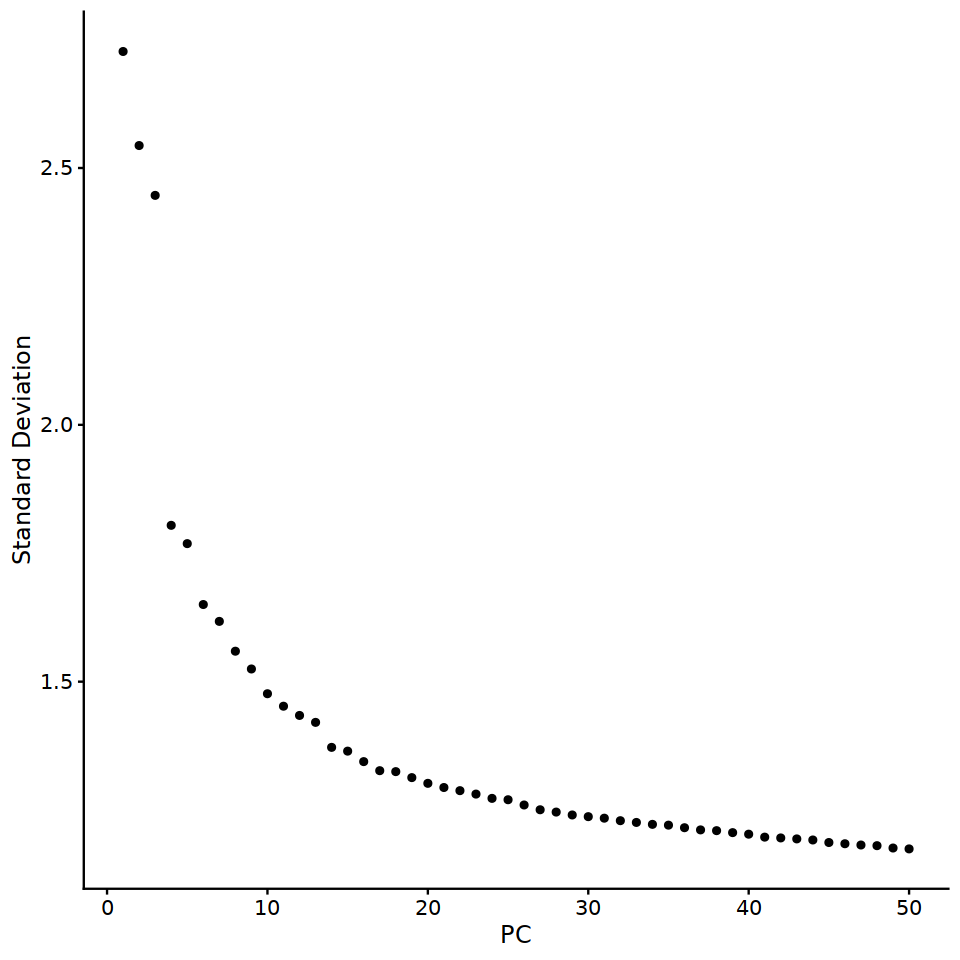

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8, warn=-1,verbose = FALSE)
ElbowPlot(treg_obj, n=50)

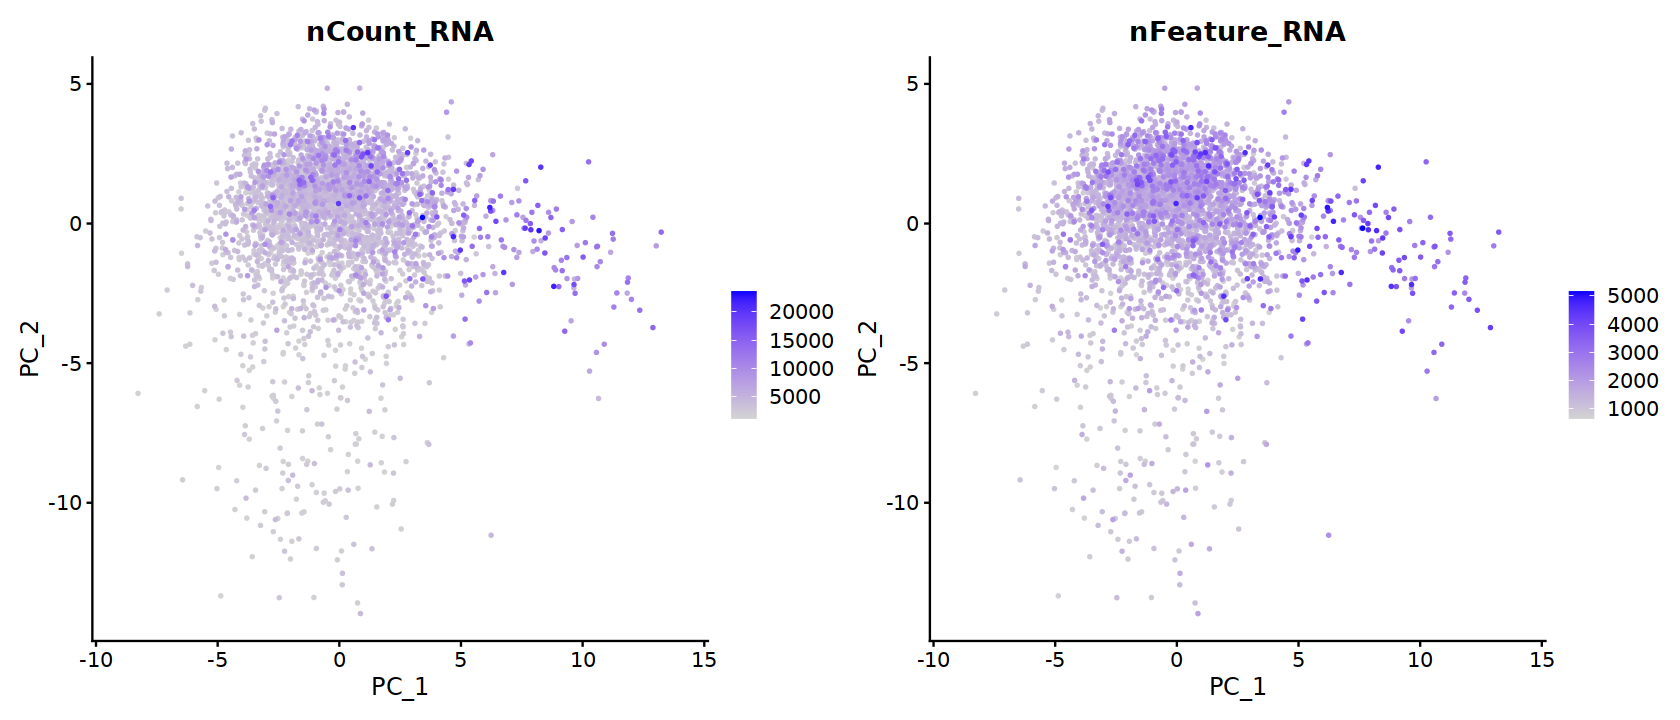

In [15]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = treg_obj, reduction = "pca",
    features = c("nCount_RNA", "nFeature_RNA"), order = T)

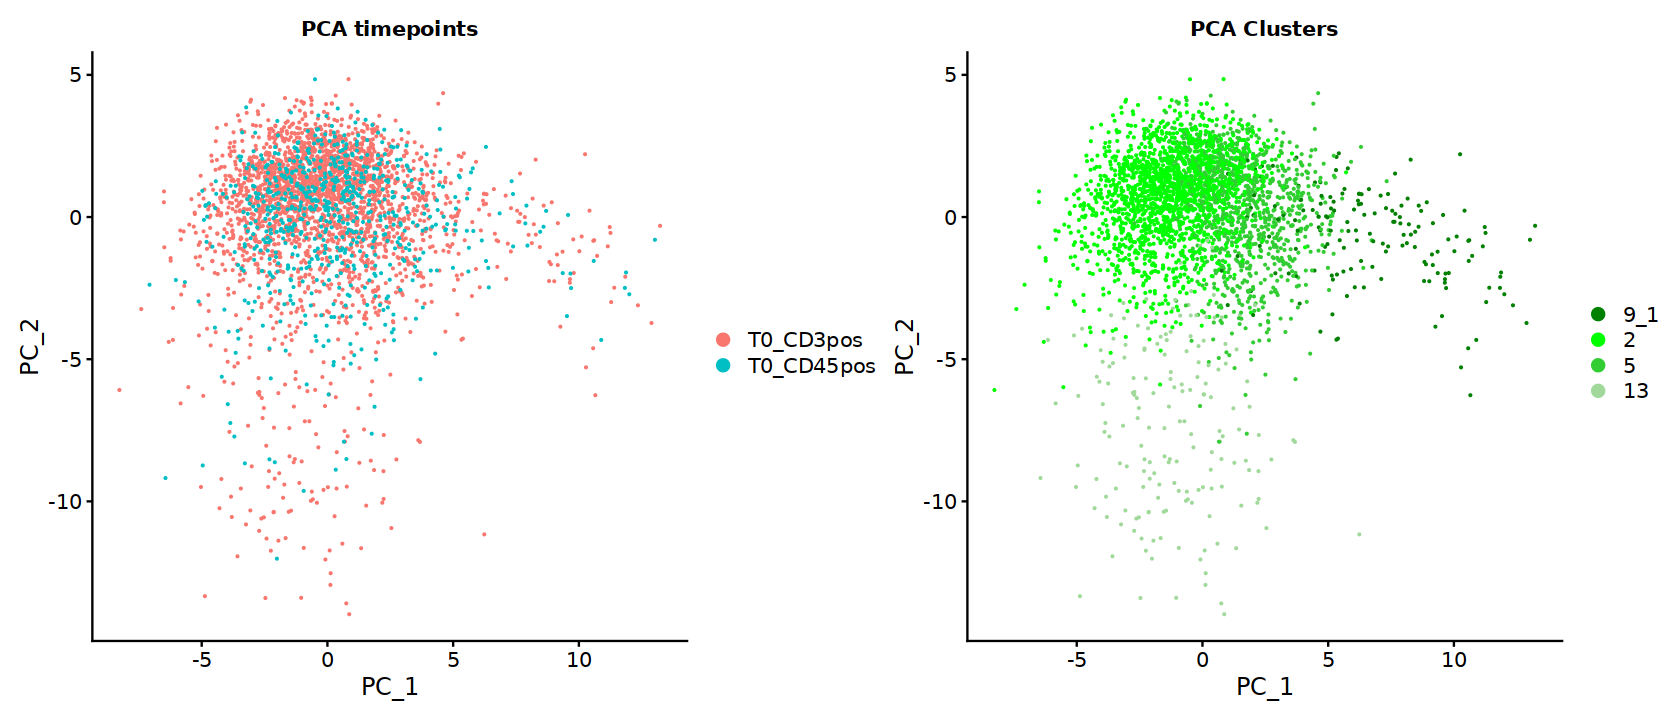

In [16]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dp1 <- DimPlot(
  treg_obj,
  reduction = "pca",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('PCA timepoints') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp2 <- DimPlot(
  treg_obj,
  reduction = "pca",
  group.by = "Tcell_clusters",
  pt.size = 0.1,
  cols = tumor_pal
) + ggtitle('PCA Clusters') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp1 + dp2

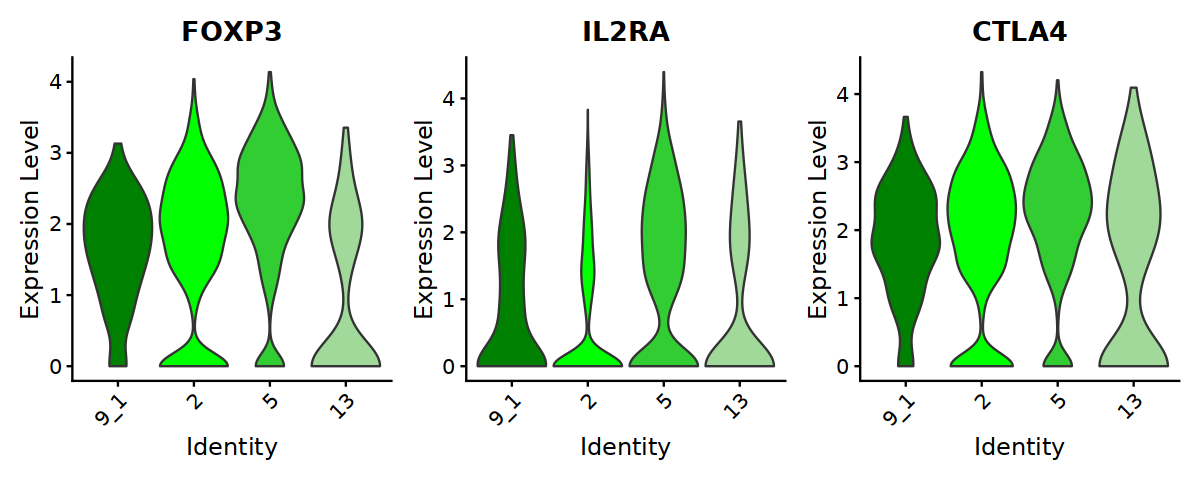

In [17]:
options(repr.plot.width =10, repr.plot.height = 4, warn=-1,verbose = FALSE)
VlnPlot(treg_obj, group.by = "Tcell_clusters",
            feature=c("FOXP3", "IL2RA", "CTLA4"),
            cols=tumor_pal, ncol=3, pt.size = 0)

In [18]:
c2_vs_c5 <- FindMarkers(treg_obj, ident.1 = "2", ident.2 = "5",logfc.threshold = 0)
c2_vs_c5$gene <- rownames(c2_vs_c5)

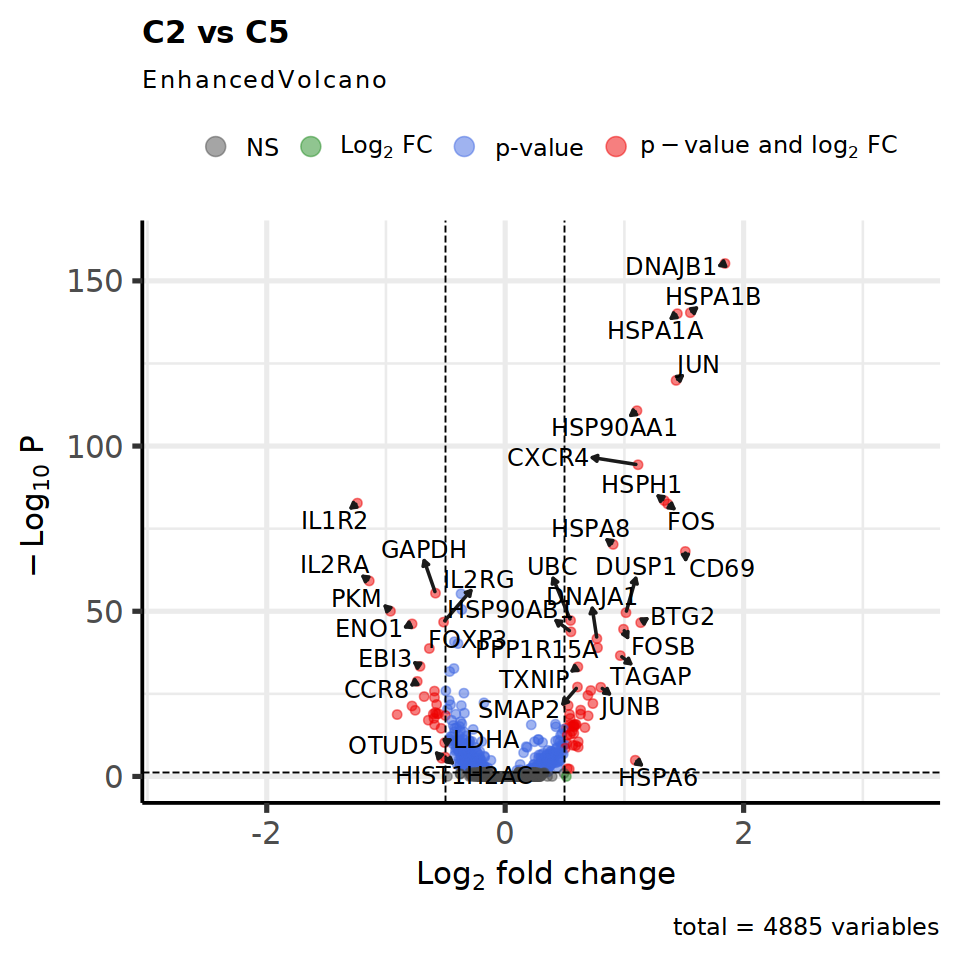

In [19]:
options(repr.plot.width =8, repr.plot.height = 8, warn=-1,verbose = FALSE)
gg_volcano_DEgenes(c2_vs_c5, "C2 vs C5", "2", "5", 0.5, 0.05)

In [20]:
markers = c("FOXP3","CTLA4","TIGIT","BATF","SELL", "IL7R","CXCR4",
            "IL2RA","IL2RB","IL2RG",
            "IL1R2","IL1RL1", "ENTPD1","FOXO1","SMAD2",
            "IKZF1","IKZF2",
            "MKI67", "STMN1", "TOP2A")

In [21]:
treg_obj$Tcell_clusters <- factor(treg_obj$Tcell_clusters, levels= c("5","2","13","9_1"))

Pseudo-bulk per cluster

In [22]:
list_objects <- SplitObject(treg_obj, split.by = "ident")
col_names <-  names(list_objects)

counts <- matrix(nrow=dim(list_objects[[1]]@assays$RNA@counts)[1], ncol=0)
lib_sizes <- c()

for (d in col_names){
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  c <- rowSums(m)
  counts <- cbind(counts, c)
  
  ls <- sum(colSums(m))
  lib_sizes <- c(lib_sizes, ls)
}
colnames(counts)<-col_names

logcpm <- counts
for (i in seq_along(names(list_objects))){
  ls <- lib_sizes[i]
  d <- colnames(logcpm)[i]
  logcpm[, d]<-log2((logcpm[, d]/ls*1e6)+1) 
}

# scaling as z-scoring 
mat1 <- t(scale(t(logcpm)))
mat1 <- mat1[unlist(markers, use.names = F),]

In [23]:
# compute pecentatge of cells expressing each gene
percent_expression <- matrix(nrow = nrow(list_objects[[1]]@assays$RNA@counts), ncol = 0)

for (d in col_names) {
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  percent_expr <- rowMeans(m > 0) * 100  # Calculate the percentage of cells with non-zero expression
  percent_expression <- cbind(percent_expression, percent_expr)
}

colnames(percent_expression) <- col_names
rownames(percent_expression) <- rownames(list_objects[[1]]@assays$RNA@counts)

In [24]:
expression_df <- as.data.frame(mat1) %>%
    rownames_to_column(var = "Gene")

expression_df <- expression_df %>%
    pivot_longer(
        cols = -Gene, 
        names_to = "CD4 Treg Clusters",  
        values_to = "Expression")

In [25]:
percent_expression_df <- as.data.frame(percent_expression) %>%
  rownames_to_column(var = "Gene") %>%
  pivot_longer(
    cols = -Gene,
    names_to = "CD4 Treg Clusters",
    values_to = "PercentExpressing"
  )
expression_df <- left_join(expression_df, percent_expression_df, by = c("Gene", "CD4 Treg Clusters"))

In [26]:
# set order
expression_df[["CD4 Treg Clusters"]] <- factor(expression_df[["CD4 Treg Clusters"]],
                                              levels=rev(c("9_1", "13", "2", "5")))

expression_df[["Gene"]] <- factor(expression_df[["Gene"]],
                                              levels=markers)

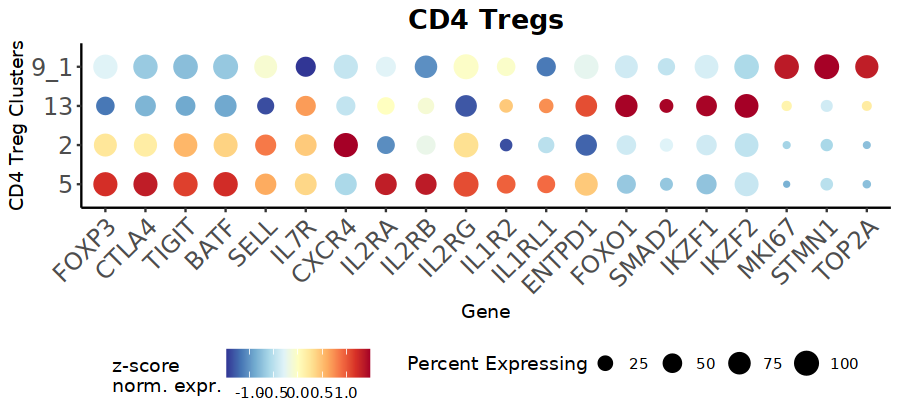

In [27]:
options(repr.plot.width = 7.5, repr.plot.height = 3.5, warn=-1,verbose = FALSE)
dp <-  ggplot(expression_df, aes(x = `CD4 Treg Clusters`, y = Gene)) +
  geom_point(aes(size = PercentExpressing, color = Expression)) +
  theme_classic() +
  scale_colour_gradientn(colors = rev(c('#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf',
                                        '#e0f3f8','#abd9e9','#74add1','#4575b4','#313695')), name = "z-score\nnorm. expr.") +
  ggtitle("CD4 Tregs") + 
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(size = 14),
        legend.position = "bottom",               
        legend.direction = "horizontal",          
        legend.box = "horizontal") +
  labs(x = "CD4 Treg Clusters", y = "Gene", color = "Expression", size = "Percent Expressing") +
  coord_flip()
dp

In [28]:
ggsave(plot = dp, width = 7.5, height = 3, dpi = 300, 
       file = here::here(glue::glue("{annot}/{plt_dir}/4.2.2-CD4_Treg_dotplot.svg")))

## T-helper

In [29]:
thelper_obj <- subset(x = seurat_obj, idents=c("6", "9_0", "11"))

In [30]:
print(table(rowSums(as.matrix(thelper_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(thelper_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
thelper_obj[['RNA']]@counts <- thelper_obj[['RNA']]@counts[rownames(keep_genes), ]
thelper_obj[['RNA']]@data <- thelper_obj[['RNA']]@data[rownames(keep_genes), ]


FALSE  TRUE 
22005  4712 


In [31]:
thelper_obj <- Seurat::DietSeurat(thelper_obj,
                           counts = TRUE,
                           data = TRUE,
                           assays = c("RNA"),
                           dimreducs = NULL,
                           graphs = NULL)

In [32]:
list_objects <- SplitObject(thelper_obj, split.by = "sample_id")
fractions <- names(list_objects)

In [33]:
find_hvgs <- function(sam, list_objects) {
    
    list_objects[[sam]] <- list_objects[[sam]]  %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4)
    
    sce <- as.SingleCellExperiment(list_objects[[sam]])
    gene_var <- modelGeneVar(sce)
    
    tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)
    
    plt <- gene_var %>% 
        as.data.frame() %>% 
        ggplot(aes(mean, total)) +
        geom_point() +
        geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
        labs(x = "Mean of log-expression", y = "Variance of log-expression") + 
        ggtitle(sam) +
        geom_text(data=tops, aes(mean,total,label=rownames(tops)))
    
    hvg <- getTopHVGs(gene_var,fdr.threshold = 0.05)
    list(plots=plt, hvgs=hvg)  
}

plts <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$plots)
hvgs <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$hvgs)

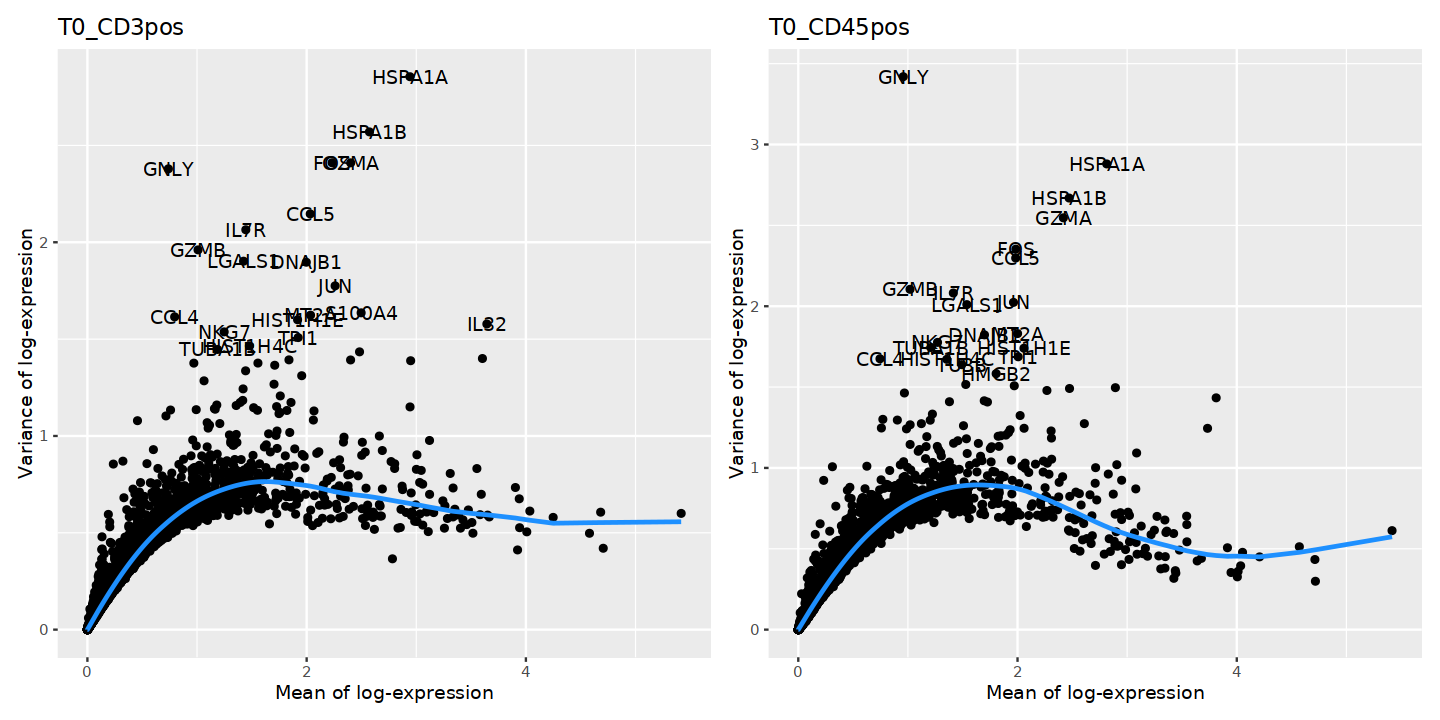

In [34]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
plts[[1]]+plts[[2]]

In [35]:
hvg_common <- union(hvgs[[1]], hvgs[[2]])
length(hvg_common)

[1] 2401

### Normalization and Embedding

In [36]:
thelper_obj <- NormalizeData(
thelper_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)
thelper_obj <- thelper_obj %>%
  ScaleData(features=hvg_common) %>% 
  RunPCA(features=hvg_common)

Centering and scaling data matrix

PC_ 1 
Positive:  GAPDH, GZMA, ACTB, IL32, TPI1, ENO1, ACTG1, S100A4, CLIC1, HMGB2 
	   MYL6, SH3BGRL3, PKM, S100A11, MT2A, TUBB, LGALS1, LDHA, CCL5, HAVCR2 
	   HIST1H1C, H2AFZ, STMN1, TUBA1B, MKI67, NKG7, HIST1H1E, CST7, GZMB, NUSAP1 
Negative:  LEF1, TCF7, CCR7, IL7R, TXK, ZBTB20, MAML2, HSPA1B, DNAJB1, FHIT 
	   CSGALNACT1, TXNIP, AFF3, SELL, HSPA1A, LEF1-AS1, FAM13A, CRYBG1, BACH2, TAFA1 
	   AL589693.1, FAAH2, PLCL1, PCSK5, SULT1B1, RPS12, LRRN3, TSPYL2, NELL2, APBA2 
PC_ 2 
Positive:  HIST1H3C, HIST1H3B, HIST1H2AH, HIST1H2AL, MKI67, HIST1H1B, HIST1H3D, RRM2, TOP2A, STMN1 
	   NUSAP1, HIST1H3H, HIST1H2BH, HIST1H2AG, HIST1H3F, ASPM, HIST1H4C, HIST1H2AI, TPX2, HIST1H2AB 
	   CENPF, HIST1H2BF, HIST1H4F, TUBA1B, HIST1H2BM, HIST2H2BF, HIST1H2BJ, TUBB, CCNB1, HIST1H2BC 
Negative:  SRGN, CST7, IL32, MYL6, CLIC1, GZMA, CCL5, GAPDH, CTLA4, HAVCR2 
	   LINC02694, S100A4, KLRB1, S100A11, RGS1, LAG3, SAT1, SH3BGRL3, TXNIP, IL10 
	   ALOX5AP, SLC2A3, CCL4, T

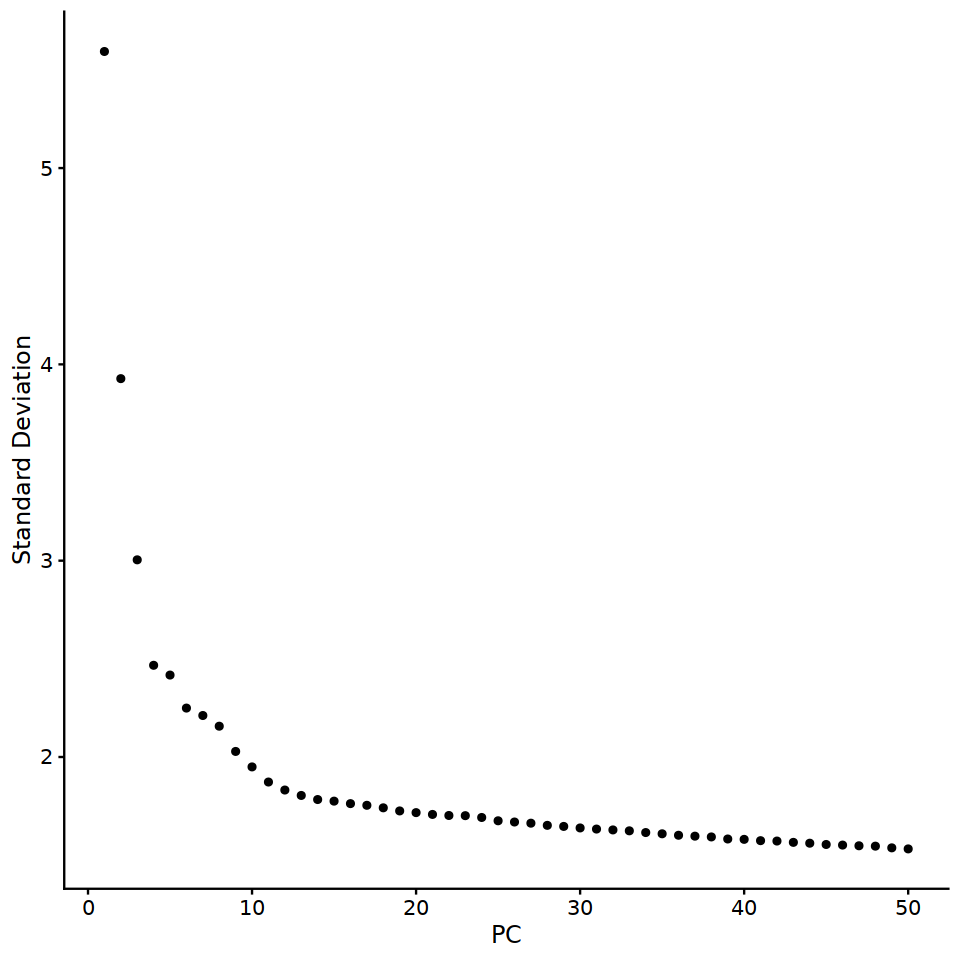

In [37]:
options(repr.plot.width = 8, repr.plot.height = 8, warn=-1,verbose = FALSE)
ElbowPlot(thelper_obj, n=50)

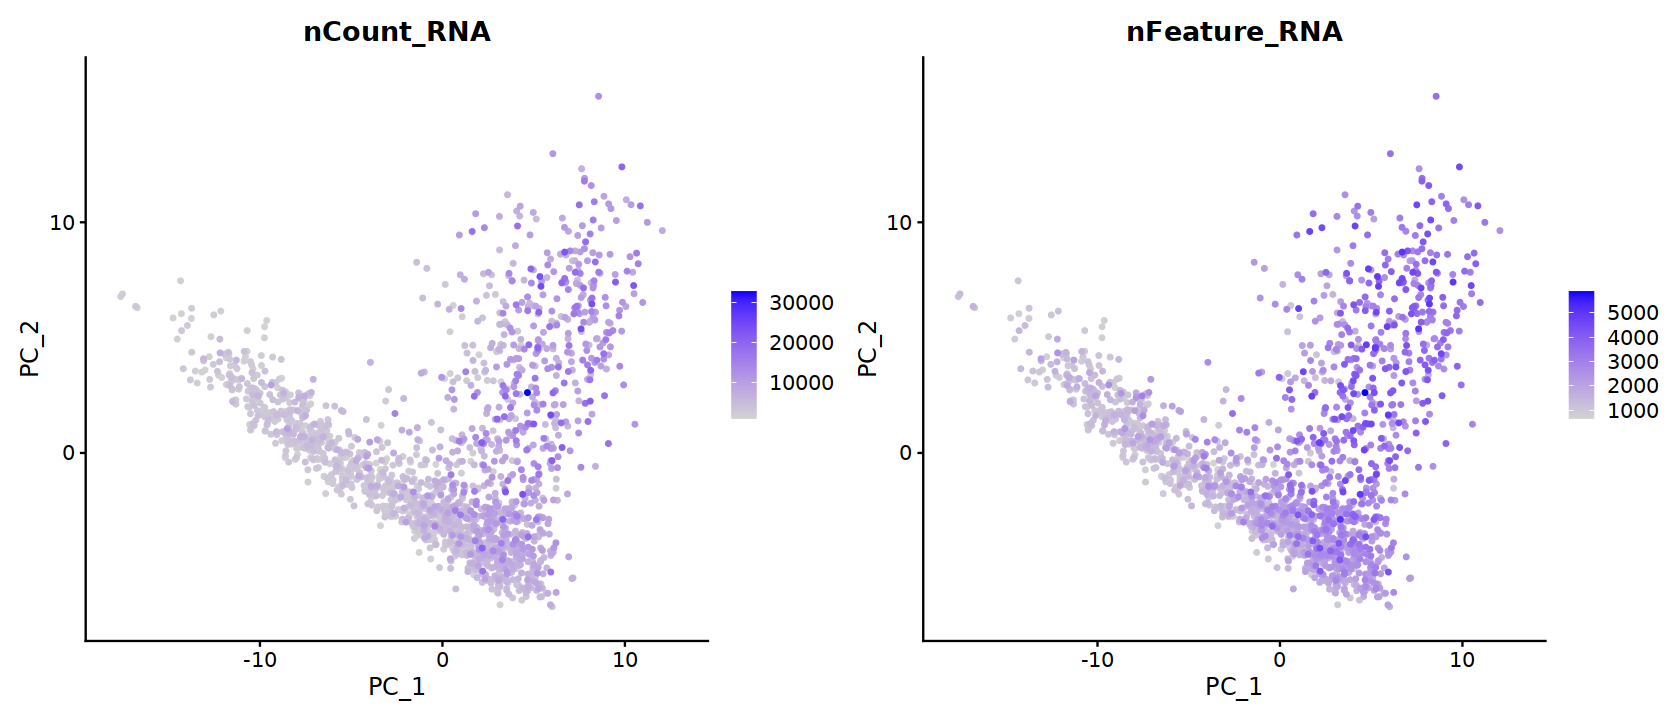

In [38]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = thelper_obj, reduction = "pca",
    features = c("nCount_RNA", "nFeature_RNA"), order = T)

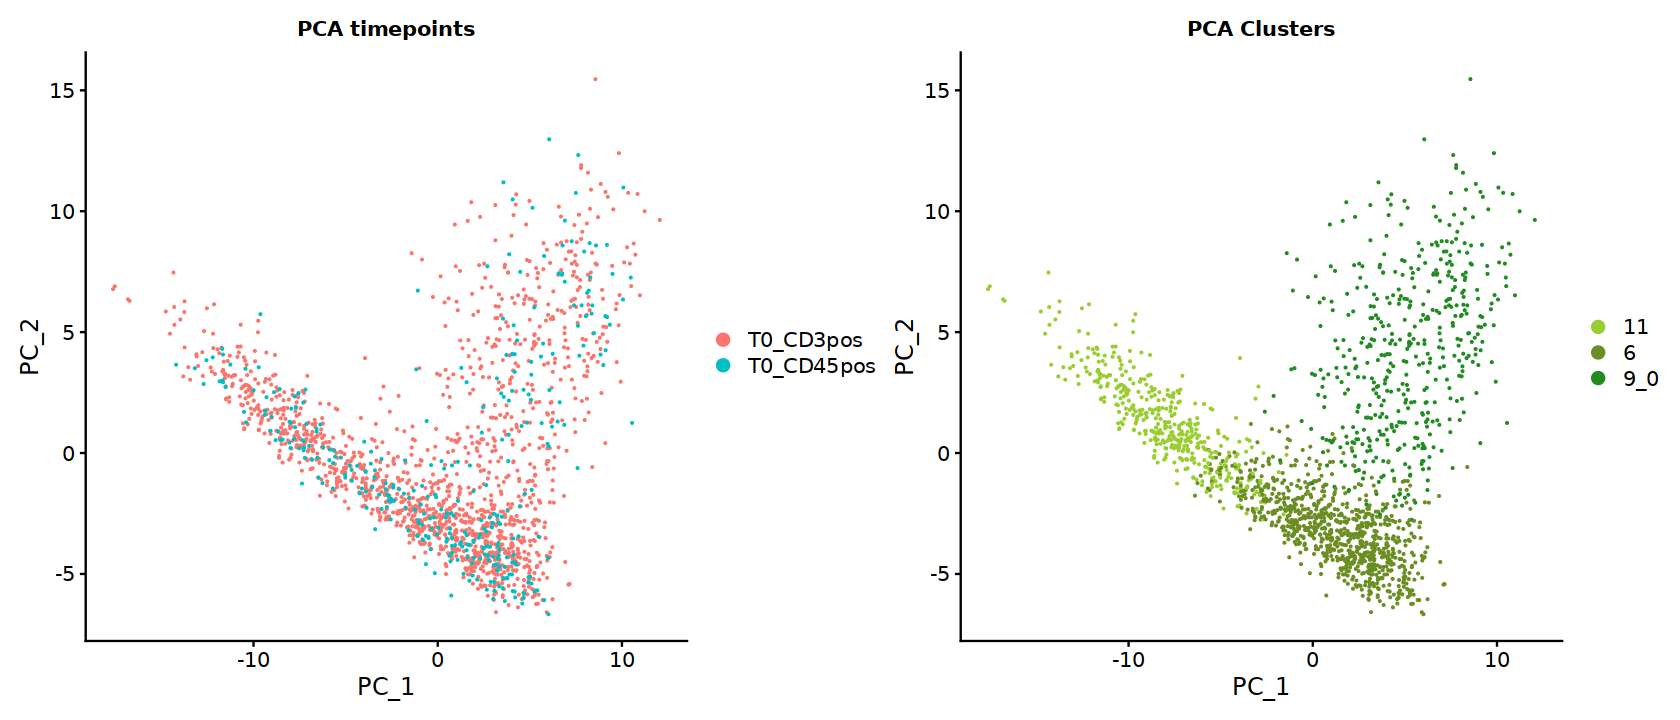

In [39]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dp1 <- DimPlot(
  thelper_obj,
  reduction = "pca",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('PCA timepoints') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp2 <- DimPlot(
  thelper_obj,
  reduction = "pca",
  group.by = "Tcell_clusters",
  pt.size = 0.1,
  cols = tumor_pal
) + ggtitle('PCA Clusters') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp1 + dp2

In [40]:
comp = 10

In [41]:
thelper_obj <- RunUMAP(
  thelper_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP"
)

09:09:59 UMAP embedding parameters a = 0.9922 b = 1.112

09:09:59 Read 1744 rows and found 10 numeric columns

09:09:59 Using Annoy for neighbor search, n_neighbors = 30

09:09:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:10:00 Writing NN index file to temp file /scratch_tmp/34329397/RtmpsW6fKJ/file10ae26605c669

09:10:00 Searching Annoy index using 1 thread, search_k = 3000

09:10:00 Annoy recall = 100%

09:10:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:10:02 Initializing from normalized Laplacian + noise (using irlba)

09:10:02 Commencing optimization for 500 epochs, with 68496 positive edges

09:10:07 Optimization finished



In [42]:
p1 <- DimPlot(
  thelper_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.5
) + ggtitle('UMAP (no integration of fractions)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

p2 <- DimPlot(
  thelper_obj,
  reduction = "umap",
  group.by = "Tcell_clusters",
  cols = tumor_pal,
  label = T,
  label.box = TRUE,
  label.size = 5,
  repel = TRUE,
  pt.size = 0.5
) + NoLegend()+ 
  labs(title="Tcell clusters") + 
     theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

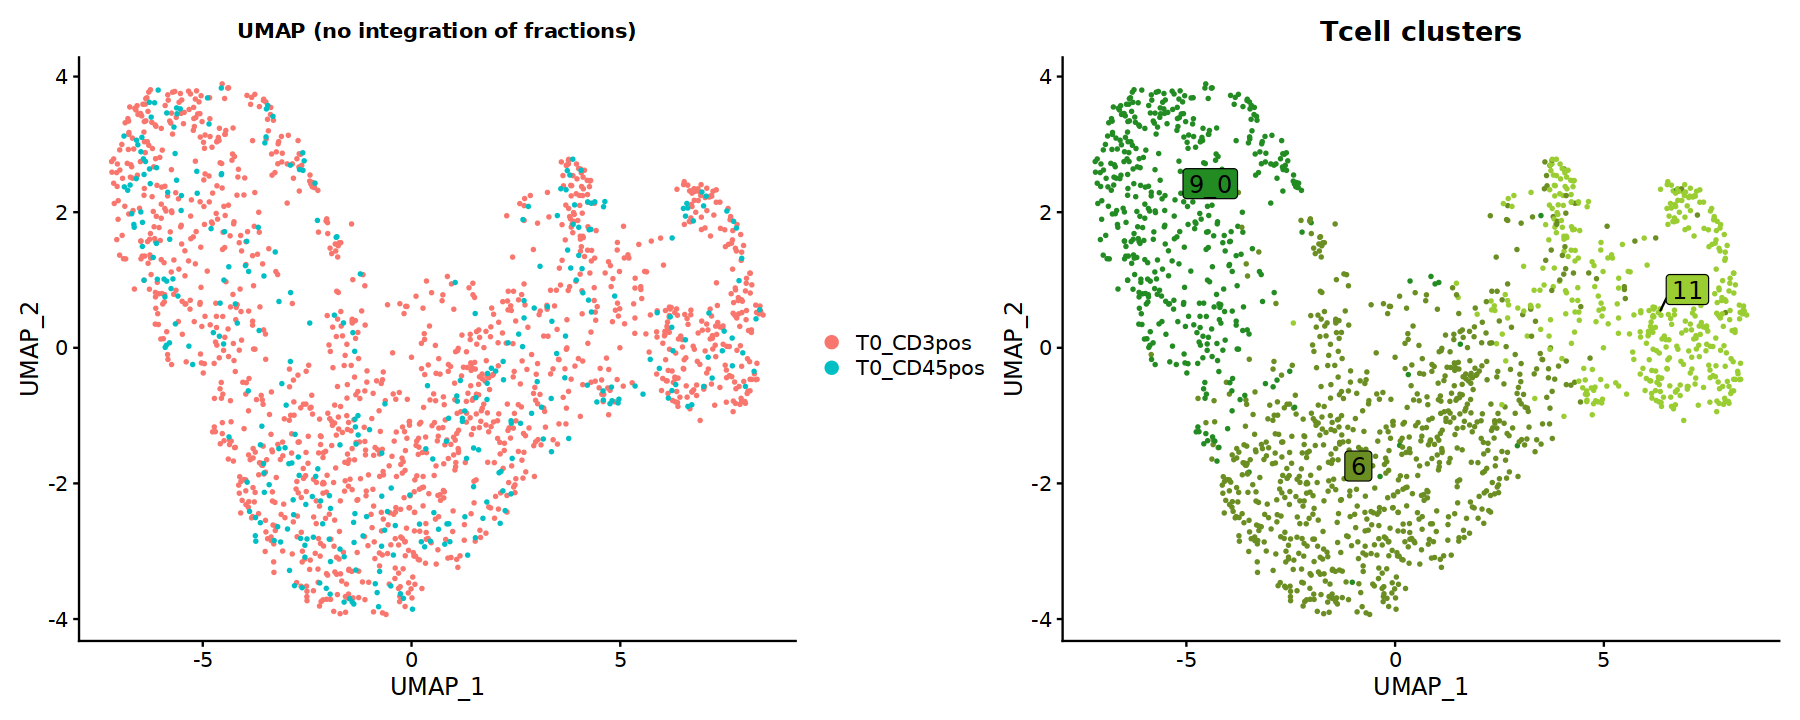

In [43]:
options(repr.plot.width = 15, repr.plot.height = 6, warn=-1,verbose = FALSE)
p1+p2

In [44]:
c6_vs_c11 <- FindMarkers(seurat_obj, ident.1 = "6", ident.2 = "11",logfc.threshold = 0)
c6_vs_c11$gene <- rownames(c6_vs_c11)

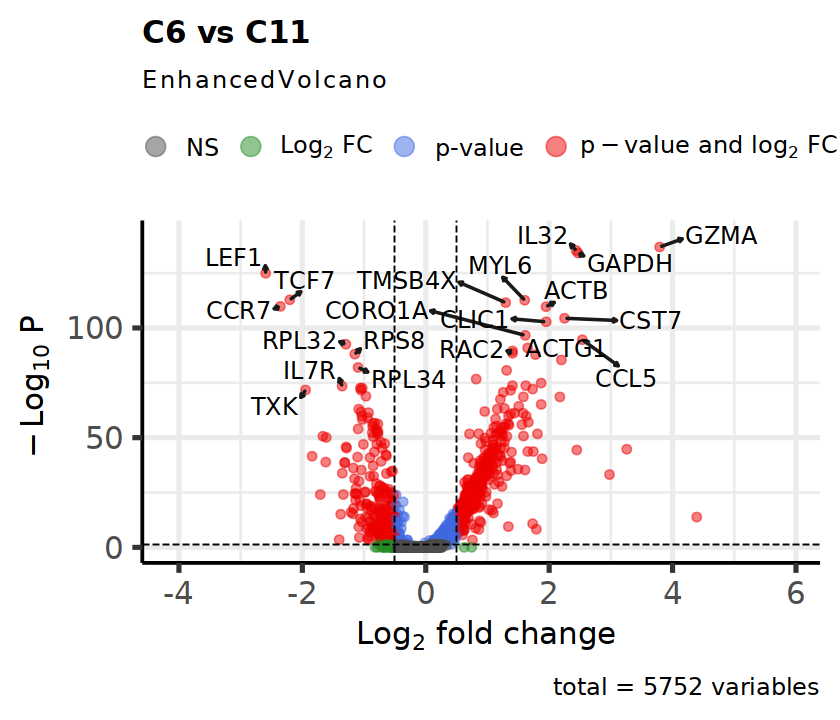

In [45]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)
gg_volcano_DEgenes(c6_vs_c11, "C6 vs C11", "6", "11", 0.5, 0.05)

In [46]:
# some markers
markers = c("SELL", "TCF7", 
            "IL2", "IFNG", "STAT4","STAT1", 
            "GATA3", "CCR4", "IL33R", 
            "IL9", "IL10", 
            "IL32R", "CCR6", "IL17A", "IL17F", "RORA", 
            "IL22", "CCR10",
            "CD40LG", "ICOS", "IL21R", "BCL6" 
           )

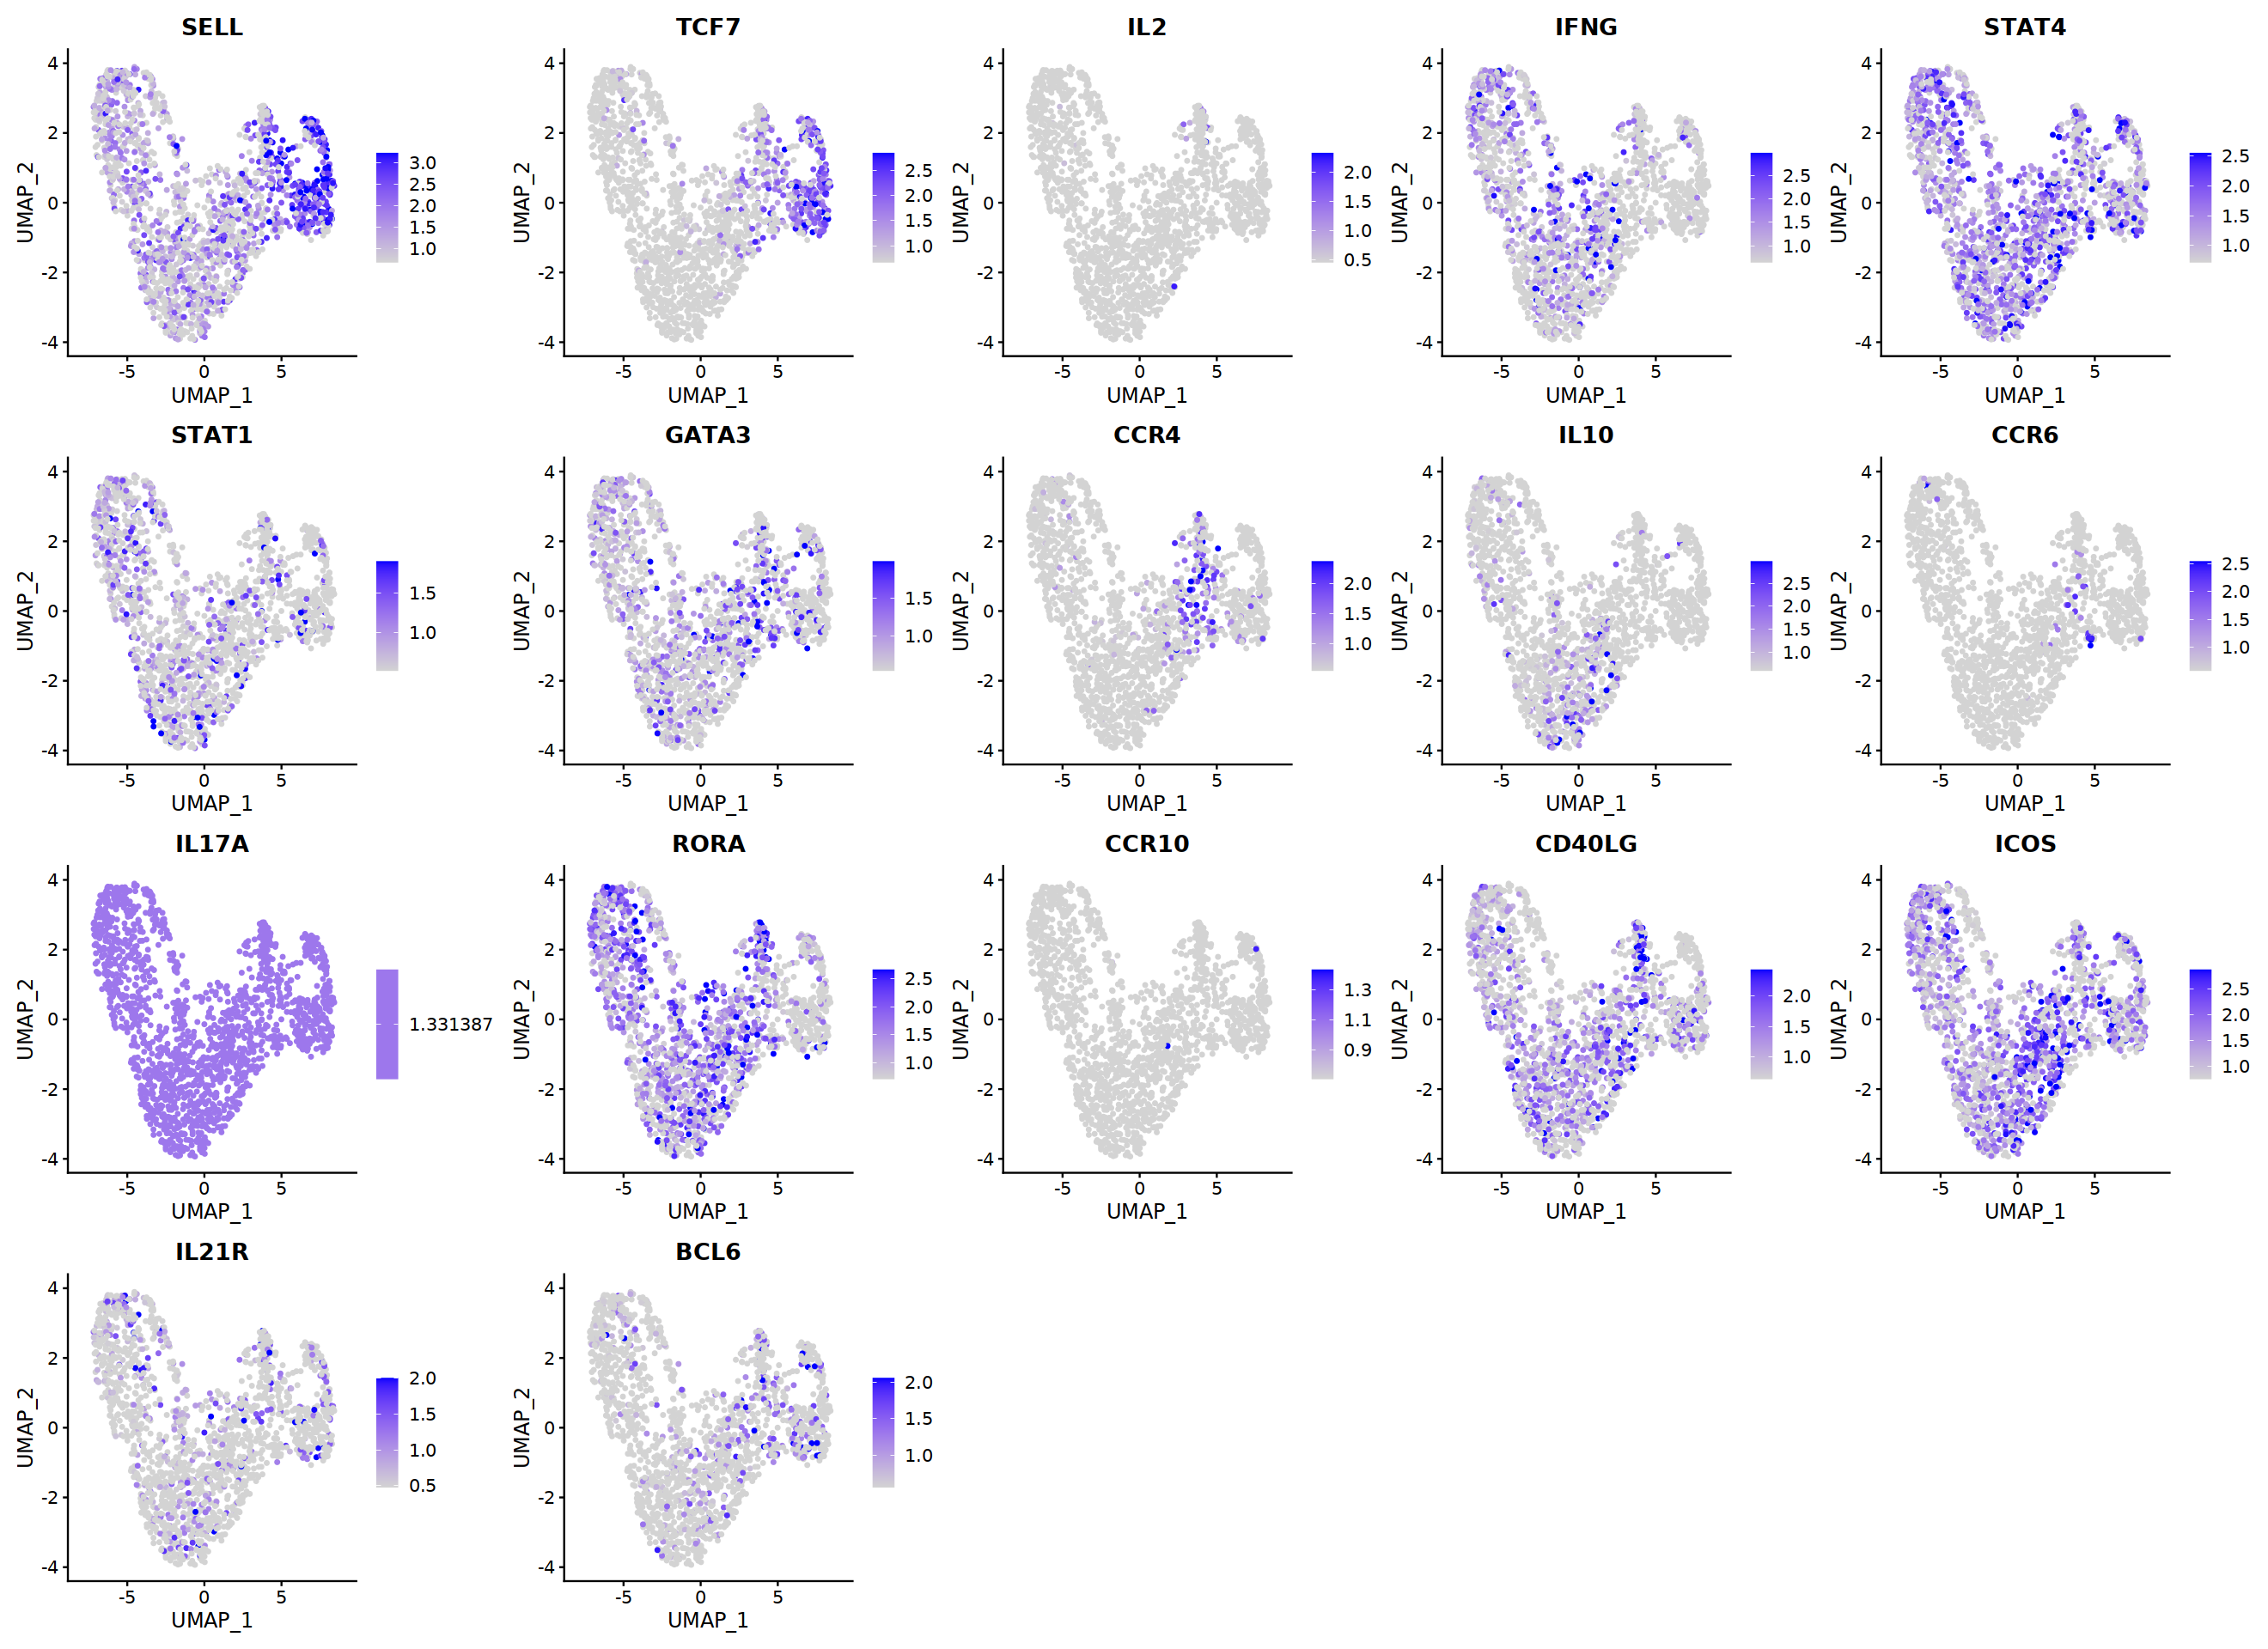

In [47]:
options(repr.plot.width = 22, repr.plot.height = 16, warn=-1,verbose = FALSE)
FeaturePlot(thelper_obj, reduction = "umap", 
            feature=markers, 
            min.cutoff = "q05", max.cutoff = "q95", ncol=5)

In [48]:
thelper_obj <- FindNeighbors(thelper_obj, reduction = "pca", 
                            dims = 1:comp)
thelper_obj <- FindClusters(thelper_obj, resolution = 0.5,cluster.name="subclustering")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1744
Number of edges: 58224

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8121
Number of communities: 6
Elapsed time: 0 seconds


In [49]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
p_sub <- DimPlot(thelper_obj, reduction = "umap", 
        label = T,
        label.box = TRUE,
        label.size = 5,
        repel = TRUE,, pt.size=0.5)+ NoLegend() +
  labs(title="Subclustering") + 
theme(plot.title = element_text(hjust = 0.5)) + 
     theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

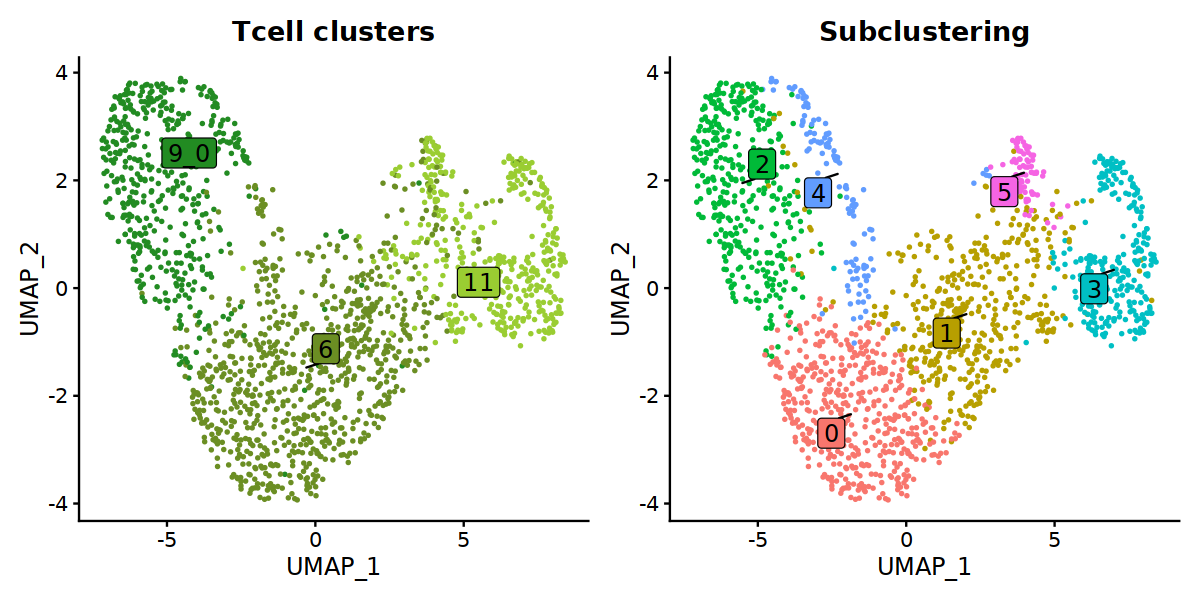

In [50]:
options(repr.plot.width = 10, repr.plot.height = 5, warn=-1,verbose = FALSE)
p2+p_sub

In [51]:
rna.markers <- FindAllMarkers(thelper_obj, min.pct=0.1, logfc.threshold=0.1, 
                              random.seed=0, max.cells.per.ident=2000, 
                              only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



In [52]:
rna.markers <- rna.markers %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC))

In [53]:
num_c=1
rna.markers %>% 
    filter(cluster == num_c) %>% 
    arrange(desc(avg_log2FC)) %>% head

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene  
KLRB1   2.240853e-26 1.2775178  0.541 0.311 4.930998e-22 1       KLRB1 
HSPA1A  8.905742e-43 1.0901755  0.941 0.841 1.959708e-38 1       HSPA1A
HSPA1B  9.957921e-45 1.0307044  0.941 0.791 2.191241e-40 1       HSPA1B
FOS     5.845759e-28 1.0079505  0.848 0.709 1.286359e-23 1       FOS   
CLDND11 3.048020e-07 0.9514006  0.530 0.506 6.707169e-03 1       CLDND1
JUN     2.427005e-31 0.9386532  0.898 0.806 5.340624e-27 1       JUN

In [54]:
thelper_obj$CD4_nonTreg <- Idents(thelper_obj)
thelper_obj$CD4_nonTreg <- paste("S", thelper_obj$CD4_nonTreg, sep="")
thelper_obj <- SetIdent(thelper_obj, value=thelper_obj@meta.data[["CD4_nonTreg"]])

In [55]:
th_pal <- c("#89a02cff", "#00BFFF", "#aad400ff", "#9ACD32", 
            "#eef4d7ff", "#d4ff2aff")
names(th_pal) <- unique(thelper_obj$CD4_nonTreg)

In [56]:
th_pal

S1          S4          S0          S3          S2          S5 
"#89a02cff"   "#00BFFF" "#aad400ff"   "#9ACD32" "#eef4d7ff" "#d4ff2aff"

In [57]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
p_sub <- DimPlot(thelper_obj, reduction = "umap", 
        label = T,
        label.box = TRUE,
        label.size = 5,
        repel = TRUE,
        pt.size=0.5,
        cols = th_pal)+ NoLegend() +
  labs(title="Subclustering") + 
theme(plot.title = element_text(hjust = 0.5)) + 
     theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

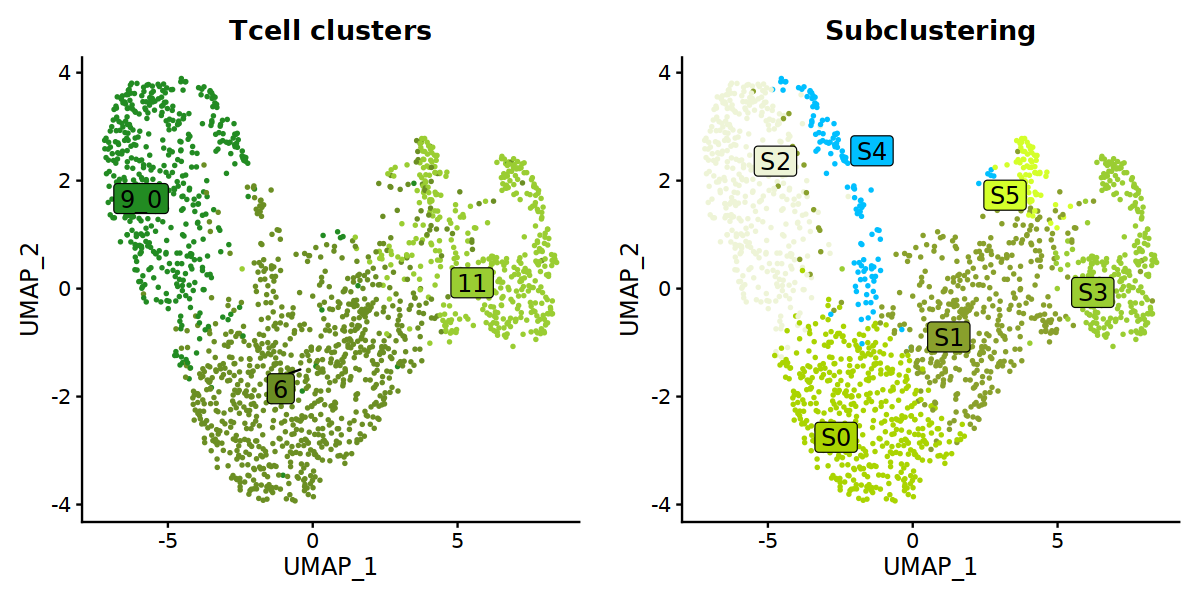

In [58]:
options(repr.plot.width = 10, repr.plot.height = 5, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list(p2, p_sub),
                   align = "hv",
                   axis = "trbl",
                   ncol = 2,
                   nrow = 1)
cp

In [59]:
ggsave(cp,width = 10, height = 5, dpi = 300, 
       file=here(glue("{annot}/{plt_dir}/4.2.2-umaps_subclustering.svg")))

Remove S4 which are actually proliferative CD8

In [60]:
num_c=4
rna.markers %>% 
    filter(cluster == num_c) %>% 
    arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene     
GNLY1       3.267151e-36 1.866314   0.700 0.211  7.189365e-32 4       GNLY     
GZMB2       1.077564e-35 1.865612   0.883 0.374  2.371179e-31 4       GZMB     
LINC024461  1.414962e-65 1.802403   0.433 0.037  3.113623e-61 4       LINC02446
NKG71       9.930089e-38 1.786281   0.975 0.560  2.185116e-33 4       NKG7     
PRF11       1.027270e-41 1.722914   0.892 0.369  2.260509e-37 4       PRF1     
CD8A       3.370921e-122 1.697486   0.700 0.052 7.417712e-118 4       CD8A

In [61]:
thelper_obj_filt <- subset(x = thelper_obj, idents=c("S0", "S1", "S2", "S5"))

In [62]:
print(table(rowSums(as.matrix(thelper_obj_filt[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(thelper_obj_filt[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
thelper_obj_filt[['RNA']]@counts <- thelper_obj_filt[['RNA']]@counts[rownames(keep_genes), ]
thelper_obj_filt[['RNA']]@data <- thelper_obj_filt[['RNA']]@data[rownames(keep_genes), ]


FALSE  TRUE 
21101   904 


In [63]:
thelper_obj_filt <- NormalizeData(
thelper_obj_filt,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

Pseudo-bulk per cluster

In [64]:
# full Th signatures
markers = list()

markers$TFh <- c("TCF7", "IL6ST", "CXCR5", "ICOS", "PDCD1", "TIGIT", "BCL6", "TOX", "BTLA", "CD40LG")
markers$Th1 <- c("CXCR3", "IFNG", "CCR5", "TNF", "TBX21", "ANXA3", "GZMK")
markers$Th2 <- c("GATA3", "MAOA", "LIMA1", "AUH", "RUNX2", "SMAD2")
markers$Th17 <- c("PALLD", "BASP1", "TNFRSF8", "IL17A", "PIK3C2B", "RUNX1", "RORC", "CCR6", "IL21")

In [65]:
list_objects <- SplitObject(thelper_obj_filt, split.by = "ident")
col_names <-  names(list_objects)

counts <- matrix(nrow=dim(list_objects[[1]]@assays$RNA@counts)[1], ncol=0)
lib_sizes <- c()

for (d in col_names){
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  c <- rowSums(m)
  counts <- cbind(counts, c)
  
  ls <- sum(colSums(m))
  lib_sizes <- c(lib_sizes, ls)
}
colnames(counts)<-col_names

logcpm <- counts
for (i in seq_along(names(list_objects))){
  ls <- lib_sizes[i]
  d <- colnames(logcpm)[i]
  logcpm[, d]<-log2((logcpm[, d]/ls*1e6)+1) 
}

# scaling as z-scoring 
mat1 <- scale(t(logcpm))
mat1 <- mat1[,unlist(markers, use.names=F)]

# Sorting clusters by CD40LG gene
mat1 <- mat1[order(mat1[,"CD40LG"]),]
df_row <- data.frame(subclusters=rownames(mat1))
row.names(df_row) <- rownames(mat1)

In [66]:
# Create a factor that indicates the functionality for each gene
gene_to_functionality <- unlist(lapply(names(markers), function(x) {
  setNames(rep(x, length(markers[[x]])), markers[[x]])
}))
functionality_factor <- factor(gene_to_functionality[colnames(mat1)], levels = names(markers))

In [67]:
col_anno <- columnAnnotation(
  Functionality = anno_block(gp = gpar(fill = 2:3, col = "black"),
                             labels = levels(functionality_factor),
                             labels_gp = gpar(col = "white", fontsize = 10))
)

In [68]:
options(repr.plot.width =10, repr.plot.height = 3, warn=-1,verbose = FALSE)
heatmap <- Heatmap(
  mat1,
  col = rev(c('#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695')),
  name = "z-score\nnorm. expr.",
  row_title = "subclusters",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  show_row_names = FALSE,
  show_column_names = TRUE,
  row_title_gp = gpar(fontsize = 14, fontface = "bold"),
  row_names_gp = gpar(fontsize = 12),
  left_annotation = rowAnnotation(
      text = anno_text(rownames(mat1), rot = 0,
                      offset = unit(1, "npc"),just = "right", 
                      height=unit(0.2, "cm")), 
      df = df_row, 
      col = list(subclusters=unlist(th_pal[rownames(mat1)])),
      show_annotation_name = FALSE,
      annotation_legend_param = list(subclusters = list( 
                                              nrow=1))),
     heatmap_legend_param = list(legend_direction = "horizontal", 
                                legend_width = unit(5, "cm")),
    column_split = functionality_factor
)
svg(here(glue("{annot}/{plt_dir}/4.2.2-subclu_helper_markers_heatmap.svg")),
   width = 12, height = 4.5)
draw(heatmap, merge_legend = TRUE, heatmap_legend_side = "bottom",
    padding = unit(c(10, 5, 20,15), "mm")) 
dev.off()

png 
  2

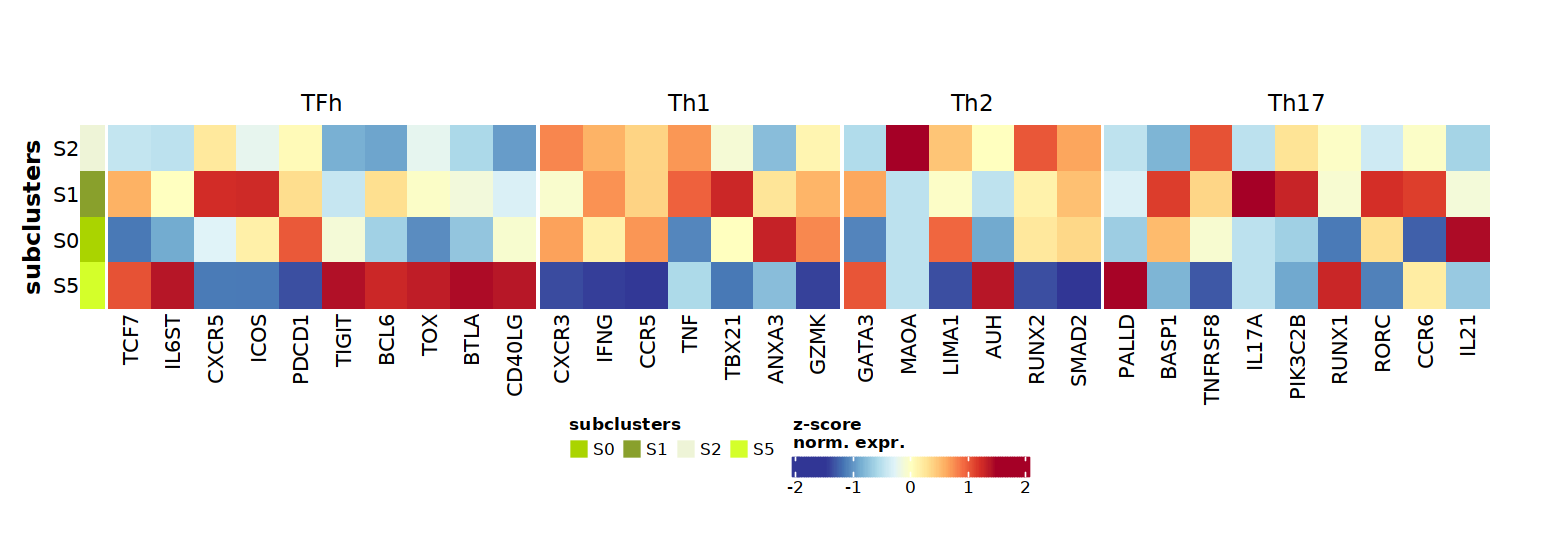

In [69]:
options(repr.plot.width = 13, repr.plot.height = 4.5, warn=-1,verbose = FALSE)
draw(heatmap, merge_legend = TRUE, heatmap_legend_side = "bottom",
    padding = unit(c(10, 5, 20,15), "mm"))

In [70]:
write_csv(rna.markers, here(glue("{annot}/{robj_dir}/4.2.2-subset_thelper.csv")))

In [71]:
saveRDS(thelper_obj, here(glue("{annot}/{robj_dir}/4.2.2-subset_thelper.rds")))

Add subclustering to main T-cell object

In [72]:
df_meta <- seurat_obj@meta.data
df_meta$barcode <- rownames(df_meta)

df_meta_sub <- thelper_obj@meta.data
df_meta_sub$barcode <- rownames(df_meta_sub)
df_meta_sub <- df_meta_sub[,c("barcode","CD4_nonTreg")]
colnames(df_meta_sub) <- c("barcode", "subclustering")

df_meta <- left_join(df_meta, df_meta_sub[,c("barcode","subclustering")], 
                     by=join_by("barcode"=="barcode"))

In [73]:
df_meta <- df_meta %>%
  mutate(subclustering = if_else(is.na(subclustering), Tcell_clusters, subclustering))

In [74]:
seurat_obj@meta.data$subclustering <- df_meta$subclustering

In [75]:
saveRDS(seurat_obj, here(glue("{annot}/{robj_dir}/4.2-subset_tcell.rds")))

## Session Info

In [76]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] EnhancedVolcano_1.13.2      ggrepel_0.9.4              
 [3] ComplexHeatmap_2.10.0       scran_1.22.1               
 [5] scater_1.22.0               scuttle_1.4.0              
 [7] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [9] Biobase_